# **Making a XOR Classifier**

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green) [![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Kh2hbPb8s_Yq9RLd-iLPUgsksu9b7iKp?usp=drive_link)

**Overview:**

This notebook demonstrates how to create a basic classifier in PyTorch, creating a basic classifier that can predict the XOR function.

### **XOR Theory**

Now we make a basic model! :D

Review: In a XOR (exclusive OR) function, the output is 1 (true) if only one of the inputs is 1 (true).

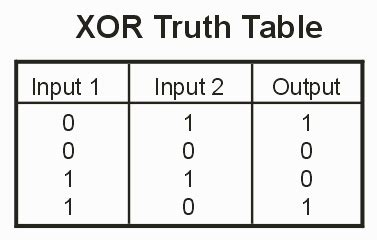

In practice, that looks like this:


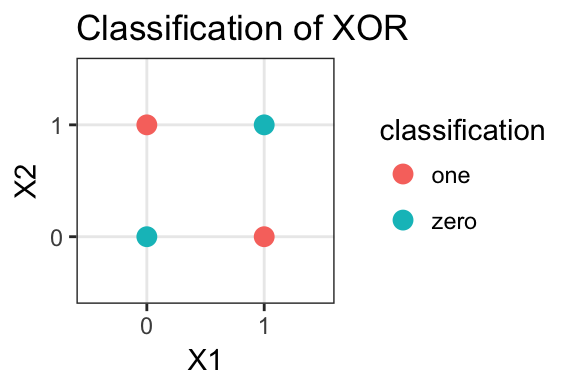

We'll try to make a classifier that can predict the output $y$ based on inputs $x_1$ and $x_2$, given the function $y$ = $x_1$ XOR $x_2$. This is a popular beginner neural network because it is was *originally* thought impossible for one neuron to correctly predict this. ([But it now is](https://medium.com/@lucaspereira0612/solving-xor-with-a-single-perceptron-34539f395182) :>)

In [ ]:
## Import common libraries we'll need later on
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba

## For making pretty progress bars when training
from tqdm.notebook import tqdm

### **XOR Classifier Module**

Let's try to make a simple classifier that looks like this, with tanh as the activation function:

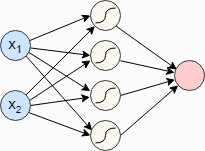

The input neurons are shown in blue, which represent $x_1$ (Input 1 in the table earlier) and $x_2$ (Input 2 in the table earlier). The hidden neurons are shown in white and have a tanh activation function, and the output neuron is in red.

In PyTorch, we can define this as follows:

In [ ]:
# Import libraries
import torch
import torch.nn as nn # the neural network toolkit, with layers + loss functions + activations
import torch.nn.functional as F # functions used in layers

In [ ]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)  # linear layer to use later on
        self.act_fn = nn.Tanh()                           # activation function
        self.linear2 = nn.Linear(num_hidden, num_outputs) # linear layer to use later on

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x) # compute hidden layer values
        x = self.act_fn(x)  # compute activation function on hidden layer values
        x = self.linear2(x) # compute output layer
        return x

**⚠️ Important:**
> **For this example, we did not add an activation layer on the final output, but other models often do (and yours probably will).** To see why we didn't put a final activation here, see the Loss section.

As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [ ]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
# Print model parameters
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


### **Datasets & dataloaders**

To load data, we will be using `data.Dataset`, and `data.DataLoader`. The dataset class provides a way to access the training/test data, while the data loader efficiently loads the data points in groups called 'batches' during training.

In [ ]:
# Import library for dataset & dataloader
import torch.utils.data as data

### **Dataset**

To use a `Dataset` in PyTorch, we only have to write its two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset.

For the XOR dataset, we can define the dataset class as follows:

In [ ]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    # Note: Only __len__ and __getitem__ are required for a Dataset to work.
    # For this example, we just write this generate_continuous_xor function to make our data for us.
    # When training on real-world data, there is no need for this since the data comes from a file.
    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx] # input
        data_label = self.label[idx] # output
        return data_point, data_label

Let's try to create such a dataset and inspect it:

In [ ]:
# Create a dataset
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))

for x in range(0, 10):
  print(f"Data point {x}:", dataset[x])

Size of dataset: 200
Data point 0: (tensor([0.8503, 0.9415]), tensor(0))
Data point 1: (tensor([0.1504, 0.9041]), tensor(1))
Data point 2: (tensor([ 0.9499, -0.0541]), tensor(1))
Data point 3: (tensor([1.0430, 0.1041]), tensor(1))
Data point 4: (tensor([0.9322, 1.2024]), tensor(0))
Data point 5: (tensor([-0.0578,  0.1461]), tensor(0))
Data point 6: (tensor([ 0.0312, -0.2440]), tensor(0))
Data point 7: (tensor([0.0965, 0.9703]), tensor(1))
Data point 8: (tensor([-0.0341,  0.9469]), tensor(1))
Data point 9: (tensor([0.8772, 1.0499]), tensor(0))


This next code cell isn't needed to actually make/train a network, but let's just write this so we can see what our data looks like.

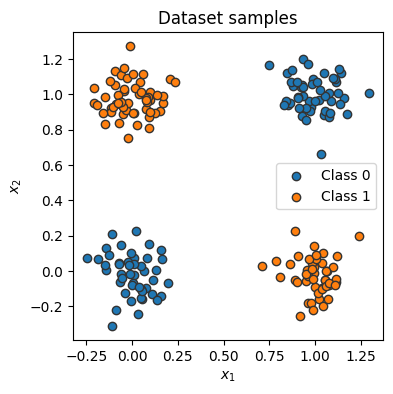

In [ ]:
# See what our dataset looks like
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy() # need to put .cpu().numpy() because numpy arrays only work on CPU. If your tensor data is on GPU, cpu() puts it on cpu, then numpy() converts it from PyTorch tensor to Numpy array
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

visualize_samples(dataset.data, dataset.label)
plt.show()

### **Dataloader**

To use a `DataLoader` in PyTorch, we just define how many data points go into each batch. In our XOR example, one data point is one 'row' (ex. $x1=1, x2=0, y=1$ is one data point). A batch of size 8 would then be 8 of these rows.

In [ ]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.0928,  0.8114],
        [ 0.0472, -0.1527],
        [ 0.8443,  1.1197],
        [ 0.9256,  1.0441],
        [ 1.0465,  1.1206],
        [-0.0201,  0.0485],
        [-0.0460,  1.1509],
        [-0.0199,  0.9503]])
Data labels torch.Size([8]) 
 tensor([1, 0, 0, 0, 0, 0, 1, 1])


### **Process for Training a Model**

 During training, we will perform the following steps:
1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

### **Loss**

PyTorch already provides its own loss functions (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions)).

For Binary Cross Entropy (BCE) loss, PyTorch has two modules: `nn.BCELoss()`, `nn.BCEWithLogitsLoss()`.

While `nn.BCELoss` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `nn.BCEWithLogitsLoss` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module `nn.BCEWithLogitsLoss`.

In [ ]:
loss_module = nn.BCEWithLogitsLoss()

### **Stochastic Gradient Descent**

PyTorch also provides the package `torch.optim` that has most popular optimizers implemented. We first use the Stochastic Gradient Descent optimizer: `torch.optim.SGD`.

In [ ]:
# Input to the optimizer are the parameters of the model: model.parameters()
# We choose the learning rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### **Training the Model**

In [ ]:
# Define training set Dataset and DataLoader
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
# Run the model on CUDA (GPU) if available, and CPU if not
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print("Device", device)

Device cuda


**⚠️ Important:**
> **When training, remember to set model.train()** to tell PyTorch to learn from the training data it sees.

In [ ]:
# Function to train the model
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

In [ ]:
# Run train function
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

### **Evaluating the Model**

In [ ]:
# Define test set Dataset and DataLoader
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

**⚠️ Important:**
> **When testing, remember to use with torch.no_grad & set model.eval()** to tell PyTorch to *not* learn from the test data it sees. This deactivates the computational graph.

In [ ]:
# Function to evaluate model
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [ ]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


### **Plotting Results**

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap.

PyTorch doesn't come with its own plotting functions for performance, so you need to write your own. We can plot our output as follows:

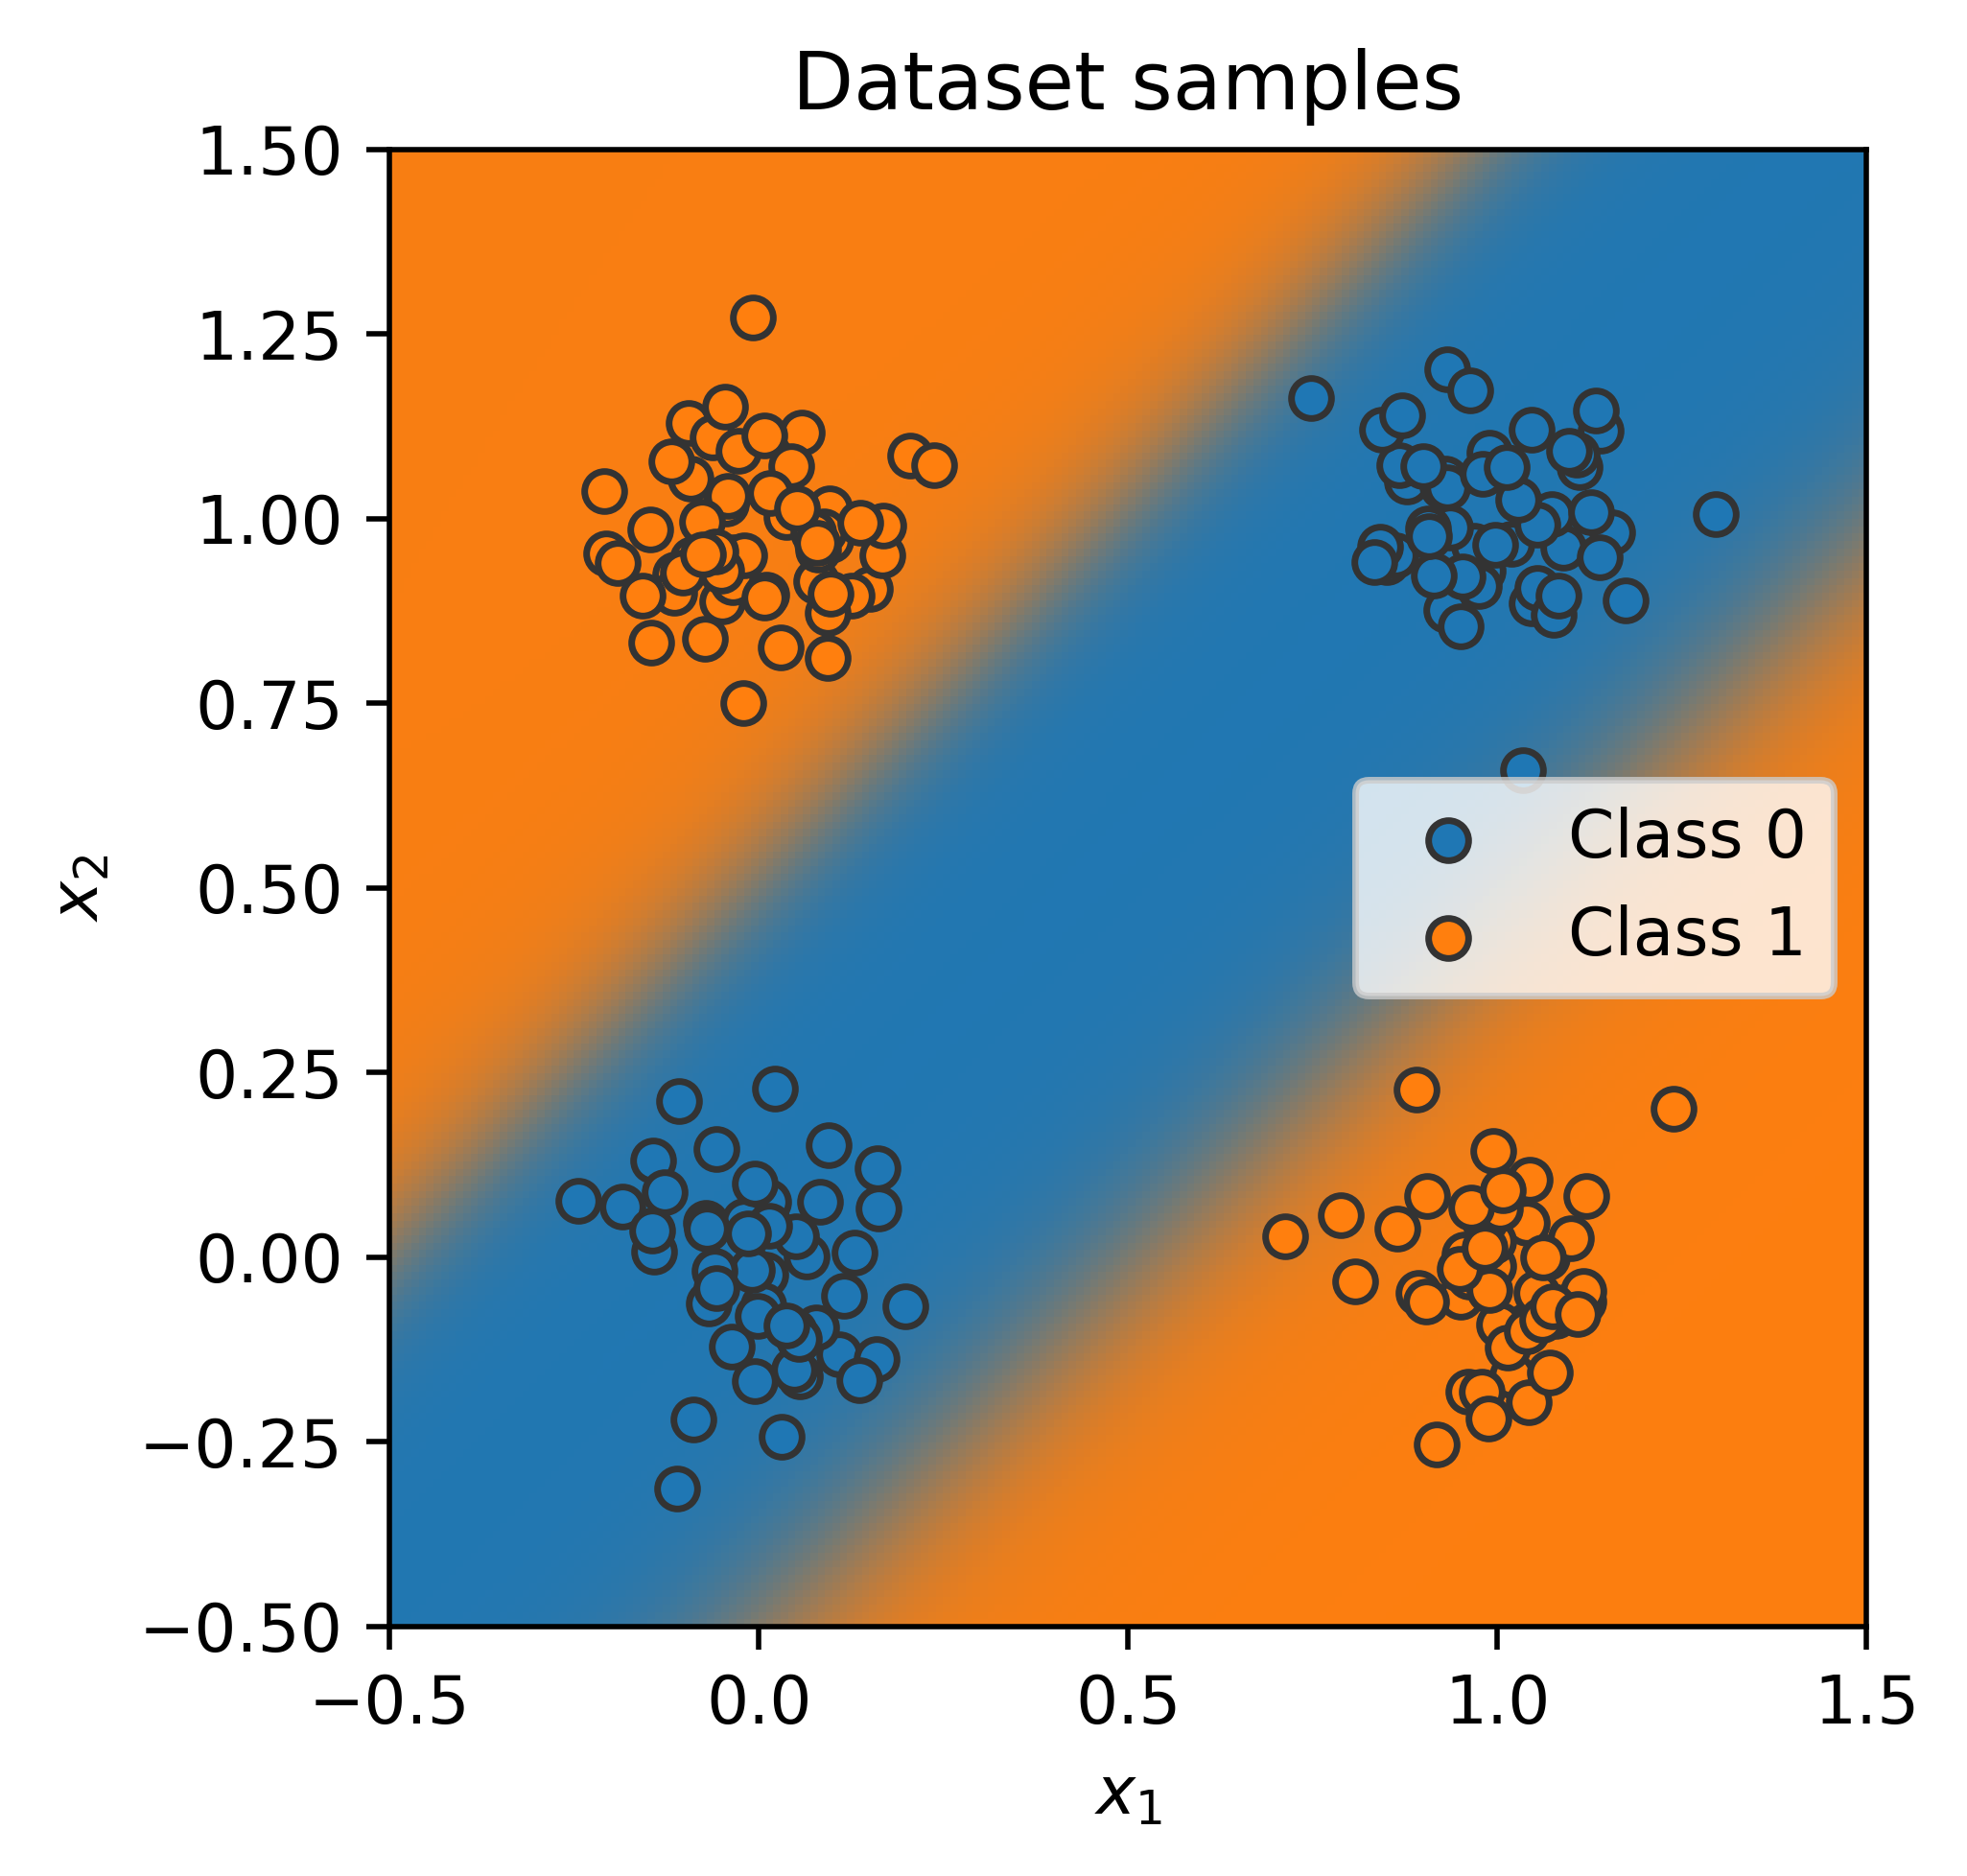

In [ ]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

### **🎉 Done!**
(ﾉﾟ▽ﾟ)ﾉ ヘ(^_^ヘ) ヾ(*д*)ﾉ゛┗(＾0＾)┓ (ノ°ο°)ノ °\(^▿^)/°

**⭐ Stuff to Try:**

1.   Make a model that can count by 1 (ex. input=2, output=3; input=4, output=5...)
2.   (Advanced) Make a one-neuron model that can predict the XOR function (See the Medium article linked somewhere above :D)

